### THIS IS A FIRST GLIMPSE OF THE DATA FOR THE PROJECT WIKISPEEDIA

In order to run this code, please add a folder named "data" that contains all the wikispeedia data. (If the folder already exist, put the data inside)

In [22]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
from bs4 import BeautifulSoup 
import os

DOWNLOAD THE DATA FROM PYTHON SCRIPT

In [23]:
directory_path = "./data"

# Vérifiez si le répertoire existe déjà
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Répertoire '{directory_path}' créé avec succès.")
else:
    print(f"Le répertoire '{directory_path}' existe déjà.")




urls=["https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz",
      "https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz"]
      #,"https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_html.tar.gz"]
      #Le dernier lien contient tous les codes htm de tous les articles wikispeedia (très lourd et jsp si on va utiliser ?)

for url in urls:    
    response=requests.get(url)
    if response.status_code==200:
        save_path="./data/"+url[43:]
        with open(save_path,"wb")as f:
            f.write(response.content)
            print(save_path+" downloaded")

PATH=["./data/wikispeedia_paths-and-graph.tar.gz",
    "./data/wikispeedia_articles_plaintext.tar.gz"]

DEST=["./data/wikispeedia_paths-and-graph",
      "./data/wikispeedia_articles_plaintext"]

for i,path in enumerate(PATH):
    with tarfile.open(path,"r:gz") as fichier:
        fichiers_names=fichier.getnames()
        for name in fichiers_names:
            fichier.extract(name, DEST[i])

Répertoire './data' créé avec succès.
./data/wikispeedia_paths-and-graph.tar.gz downloaded
./data/wikispeedia_articles_plaintext.tar.gz downloaded


Utilisation des données sur les finished paths

In [28]:
PATH="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"


finished_path=pd.read_csv(PATH, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()} \t Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07 	 Last Date 2014-01-15 


                            Name  Count
0  Actors_models_and_celebrities     25
1                        Artists     36
2     Astronomers_and_physicists     21
3                       Chemists      8
4               Computing_People      9


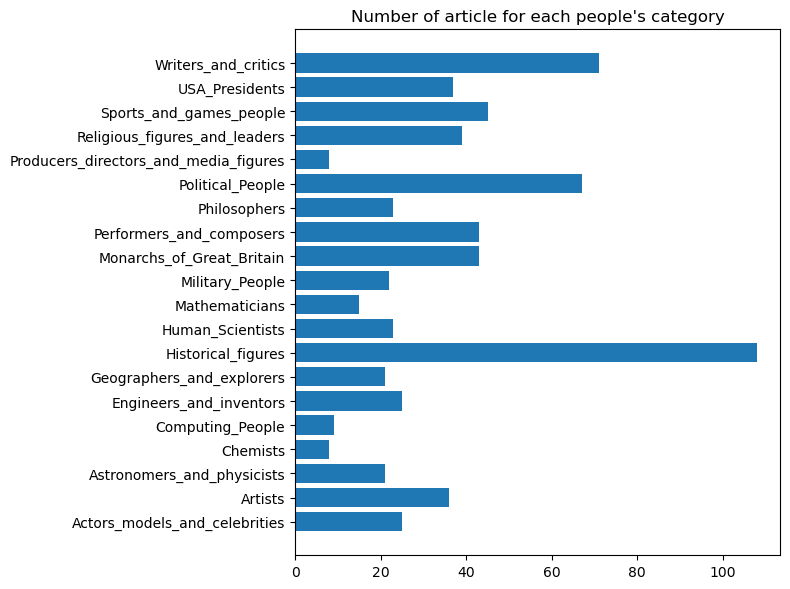

In [31]:
path = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv"

categories = pd.read_csv(path,header = 12, delimiter='\t',names=["article","categories"])
categories['article'] = categories['article'].apply(lambda x :(urllib.parse.unquote(x , encoding = 'utf-8'))) # Decode article names

people = categories[categories['categories'].str.contains('subject.People')].copy() # Dataset of people
people['categories'] = people['categories'].apply(lambda x : x[len('subject.People.'):]) # Remove useless string

#print(people.head())
#print(people.shape)
#print(people.categories.unique(),len(people.categories.unique()))
counts = people.groupby('categories').count()
counts = counts.reset_index()
counts.columns = ["Name", "Count"]
print(counts.head())

plt.figure(figsize=(8, 6))

plt.barh(counts["Name"], counts['Count'])
plt.title("Number of article for each people's category")
plt.xticks(rotation=0)
plt.tight_layout()

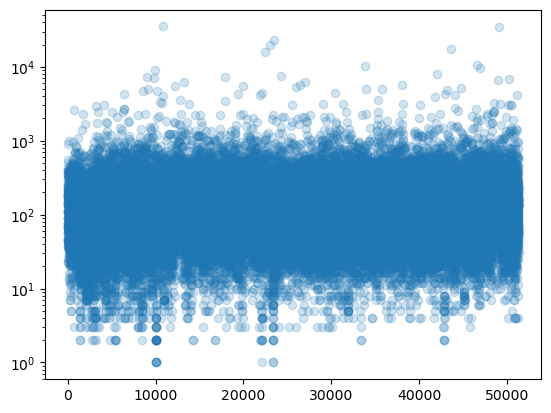

In [32]:
fig,ax=plt.subplots()
fig=plt.scatter(finished_path.index, finished_path["durationInSec"], alpha=0.2)
ax.set_yscale("log")

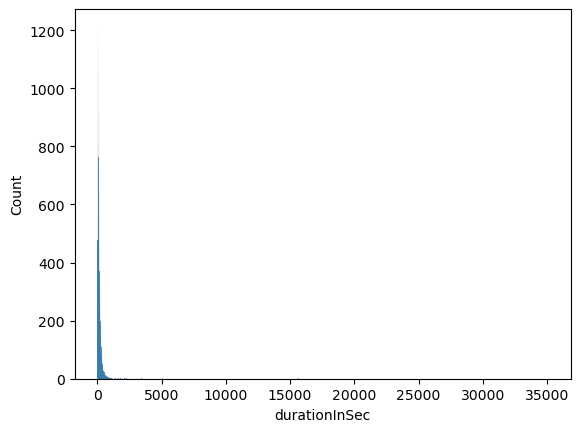

In [33]:
ax=sns.histplot(finished_path["durationInSec"], bins=10000)

Text(0, 0.5, 'Duration [s]')

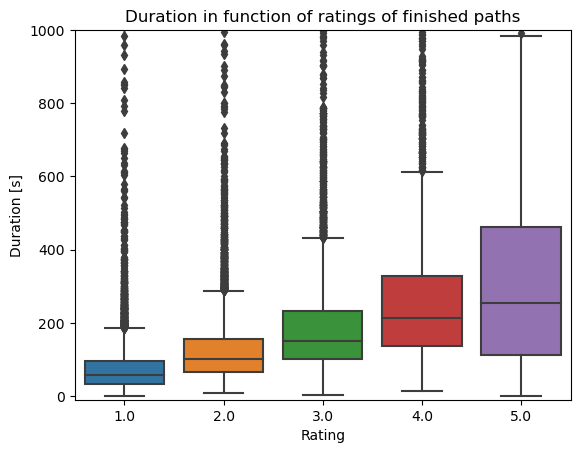

In [34]:

ax=sns.boxplot(x="rating", y="durationInSec", data=finished_path)
ax.set_ylim([-10,1000])
ax.set_title("Duration in function of ratings of finished paths")
ax.set_xlabel("Rating")
ax.set_ylabel("Duration [s]")
